# Introduction

This notebook performs the main language-modeling experiments for the paper "Agglomerative Attention" by Matthew Spellings. For a plaintext description of the experiments, please see the paper.

## `keras_transformer` Installation

This notebook requires a modified version of [`keras_transformer`](https://github.com/kpot/keras-transformer), which was developed by [Kirill Mavreshko](https://github.com/kpot). The modified version can be installed from source as follows:

```
git clone https://github.com/klarh/keras-transformer
pip install -e ./keras-transformer
```

This notebook utilizes lightly modified code from the `keras_transformer` examples to generate the wikitext-2 data and build the language model. The `keras_transformer` project is made available under the MIT license, reproduced below.

<div style="font-size: 80%; font-family: monospace;"><pre>
The MIT License

Copyright 2018 Kirill Mavreshko (https://www.linkedin.com/in/kirill-mavreshko/)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is furnished
to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included
in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM,
DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,
TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</pre></div>

In [1]:
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib, matplotlib.pyplot as pp
import sys
import tensorflow as tf
import timeit
import collections
import itertools
import tqdm
import keras_tqdm
import pandas as pd

import keras_transformer
import keras_transformer.attention

tqdm.tqdm = tqdm.tqdm_notebook

# assume that the keras_transformer package is installed
# in developer mode (used when we import example later)
sys.path.append(os.path.join(os.path.dirname(keras_transformer.__file__), '..'))

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
session = tf.Session(config=tf_config)
K.set_session(session)

Using TensorFlow backend.


In [2]:
from time import time

from keras.layers import Input, Softmax, Embedding, Add, Lambda, Dense

from keras_transformer.extras import ReusableEmbedding, TiedOutputEmbedding
from keras_transformer.position import TransformerCoordinateEmbedding
from keras_transformer.transformer import TransformerACT, TransformerBlock

def perplexity(y_true, y_pred):
    """
    Popular metric for evaluating language modelling architectures.
    More info: http://cs224d.stanford.edu/lecture_notes/LectureNotes4.pdf
    """
    cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
    return K.mean(K.exp(K.mean(cross_entropy, axis=-1)))

def bpc(y_true, y_pred):
    """Bits per character metric, commonly used for compression-type tasks."""
    cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
    return K.mean(cross_entropy)/np.log(2)

class TimingCallback(keras.callbacks.Callback):
    """Measure the time required for each epoch"""
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = time()
        
    def on_epoch_end(self, epoch, logs={}):
        logs['epoch_time'] = time() - self.starttime
        
def universal_transformer_gpt_model(
        max_seq_length: int, vocabulary_size: int,
        word_embedding_size: int, transformer_depth: int,
        num_heads: int, transformer_dropout: float = 0.1,
        embedding_dropout: float = 0.6,
        l2_reg_penalty: float = 1e-6,
        confidence_penalty_weight: float = 0.1,
        agglomerative_attention: bool = False,
        use_convolutions: bool = False,
        use_coordinate_embeddings: bool = True,
        convolution_width: int = 0,
        penalize_confidence: bool = False):
    """
    A model which is similar to the one described by OpenAI in paper
    "Improving Language Understanding by Generative Pre-Training", except
    that it relies L2 regularization of the word embedding matrix
    (instead of the dropout), and uses Universal Transformer architecture.
    Derived from the keras-transformer project examples.
    """
    word_ids = Input(shape=(max_seq_length,), dtype='int32', name='word_ids')
    l2_regularizer = (keras.regularizers.l2(l2_reg_penalty) if l2_reg_penalty
                      else None)
    embedding_layer = ReusableEmbedding(
        vocabulary_size, word_embedding_size,
        input_length=max_seq_length,
        name='bpe_embeddings',
        # Regularization is based on paper "A Comparative Study on
        # Regularization Strategies for Embedding-based Neural Networks"
        # https://arxiv.org/pdf/1508.03721.pdf
        embeddings_regularizer=l2_regularizer)
    output_layer = TiedOutputEmbedding(
        projection_regularizer=l2_regularizer,
        projection_dropout=embedding_dropout,
        name='word_prediction_logits')
    conv_layer = keras.layers.Conv1D(
        word_embedding_size, convolution_width, padding='causal',
        activation='relu', kernel_initializer='he_uniform', name='convolution')
    coordinate_embedding_layer = TransformerCoordinateEmbedding(
        transformer_depth,
        name='coordinate_embedding')
    transformer_block = TransformerBlock(
        name='transformer', num_heads=num_heads,
        residual_dropout=transformer_dropout,
        attention_dropout=transformer_dropout,
        use_masking=True, vanilla_wiring=False,
        agglomerative_attention=agglomerative_attention)
    transformer_act_layer = TransformerACT(name='adaptive_computation_time')
    output_softmax_layer = Softmax(name='word_predictions')

    next_step_input, embedding_matrix = embedding_layer(word_ids)
    act_output = next_step_input

    for i in range(transformer_depth):
        if use_convolutions:
            next_step_input = conv_layer(next_step_input)
        if use_coordinate_embeddings:
            next_step_input = coordinate_embedding_layer(next_step_input, step=i)
        next_step_input = transformer_block(next_step_input)
        next_step_input, act_output = transformer_act_layer(next_step_input)

    transformer_act_layer.finalize()
    next_step_input = act_output
    word_predictions = output_softmax_layer(
        output_layer([next_step_input, embedding_matrix]))
    model = keras.models.Model(inputs=[word_ids], outputs=[word_predictions])
    # Penalty for confidence of the output distribution, as described in
    # "Regularizing Neural Networks by Penalizing Confident
    # Output Distributions" (https://arxiv.org/abs/1701.06548)
    confidence_penalty = K.mean(
        confidence_penalty_weight *
        K.sum(word_predictions * K.log(word_predictions), axis=-1))
    if penalize_confidence:
        model.add_loss(confidence_penalty)
    return model        
        
def get_model(max_seq_length, agglomerative_attention, 
              vocabulary_size, embedding_size, num_heads, 
              use_convolutions=False, 
              use_coordinate_embeddings=True,
              convolution_width=0,
              adjust_lr=False):
    
    optimizer = keras.optimizers.adadelta()
    model = universal_transformer_gpt_model(
        max_seq_length=max_seq_length,
        vocabulary_size=vocabulary_size,
        word_embedding_size=embedding_size,
        transformer_depth=5,
        num_heads=num_heads,
        agglomerative_attention=agglomerative_attention,
        use_convolutions=use_convolutions,
        use_coordinate_embeddings=use_coordinate_embeddings,
        convolution_width=convolution_width)
    model.compile(
        optimizer,
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[perplexity, bpc])
        
    model_callbacks = [
        TimingCallback(),
        keras_tqdm.TQDMNotebookCallback(show_inner=False),
        keras.callbacks.EarlyStopping(
            'val_loss', patience=10, restore_best_weights=True),
    ]
    
    if adjust_lr:
        model_callbacks.append(
            keras.callbacks.ReduceLROnPlateau(factor=.9, patience=3))
    
    return model, model_callbacks


# WikiText-2 Dataset

In [3]:
from itertools import islice
from typing import Iterable, List, Optional

from example import wikitext
from example.bpe import BPEEncoder, ID_FOR_PADDING

def pad_lm_samples(samples: Iterable[List[int]],
                   required_sequence_length: int):
    tail_padding = [ID_FOR_PADDING]
    for sample in samples:
        assert len(sample) > 0
        sample.extend(tail_padding * (required_sequence_length - len(sample)))


def training_data_to_samples(training_set_name: str,
                             encoder: BPEEncoder,
                             max_sequence_length: int) -> np.ndarray:
    """
    Reads WikiText dataset, interpreting each line as an independent sequence,
    then splits those lines with BPE tokenizer and turns them into word ids
    based on previously constructed BPE vocabulary (both the tokenizer
    and the vocabulary are parts of the BPEEncoder instance).

    Those word id's then packed into a matrix the size of
    (number of lines x max_sequence_length + 1), which can be later sliced
    to get X and Y matrices of sequences for training).
    """
    training_set = wikitext.read_wikitext_file(training_set_name)
    useful_sequences = []
    for line in training_set.splitlines():
        clean_line = line.strip()
        is_header = clean_line.startswith('=') and clean_line.endswith('=')
        if is_header or not clean_line:
            continue
        # the encoder is supposed to add <SEQ> and </SEQ>
        id_word_pairs = list(encoder(clean_line))
        useful_sequences.append(
            [word_id for word_id, _ in id_word_pairs[:max_sequence_length]])

    pad_lm_samples(useful_sequences, max_sequence_length + 1)
    result = np.empty(
        (len(useful_sequences), max_sequence_length + 1),
        dtype='int32')
    for i, sequence in enumerate(useful_sequences):
        result[i, :] = sequence
    return result


def training_data_to_dense_samples(training_set_name: str,
                                   encoder: BPEEncoder,
                                   max_sequence_length: int) -> np.ndarray:
    """
    Reads WikiText dataset, interpreting each line as an independent sequence,
    then splits those lines with BPE tokenizer and turns them into word ids
    based on previously constructed BPE vocabulary (both the tokenizer
    and the vocabulary are parts of the BPEEncoder instance).

    Those word id's then packed into a matrix the size of
    (number of lines x max_sequence_length + 1), which can be later sliced
    to get X and Y matrices of sequences for training).
    """
    training_set = wikitext.read_wikitext_file(training_set_name)
    useful_sequences = []

    def stream_bpe_tokens():
        for line in training_set.splitlines():
            clean_line = line.strip()
            if not clean_line:
                continue
            # the encoder is supposed to add <SEQ> and </SEQ>
            id_word_pairs = encoder(clean_line)
            yield from id_word_pairs

    id_word_stream = stream_bpe_tokens()
    while True:
        chunk = list(islice(id_word_stream, max_sequence_length))
        if len(chunk) == 0:
            break
        sample_sequence = [word_id for word_id, _ in chunk]
        useful_sequences.append(sample_sequence)

    pad_lm_samples(useful_sequences, max_sequence_length + 1)
    result = np.empty(
        (len(useful_sequences), max_sequence_length + 1),
        dtype='int32')
    for i, sequence in enumerate(useful_sequences):
        result[i, :] = sequence
    return result

def train_wikitext2(batch_size, max_seq_length, embedding_size, 
                    num_heads, agglomerative_attention, epochs,
                    use_convolutions=False, use_coordinate_embeddings=True):
    encoder = wikitext.build_wikitext_bpe_encoder()

    def x_y_for_dataset(dataset_name):
        fat_sample = training_data_to_dense_samples(
            dataset_name, encoder, max_seq_length)
        _x = fat_sample[:, :max_seq_length]
        _y = np.expand_dims(fat_sample[:, 1:], axis=-1)
        return _x, _y

    x, y = x_y_for_dataset(wikitext.TRAINING_SET_NAME)
    
    model, model_callbacks = get_model(max_seq_length, agglomerative_attention, 
          encoder.vocabulary_size(), embedding_size, num_heads,
          use_convolutions, use_coordinate_embeddings, convolution_width=8)
    
    model.fit(
        x, y,
        validation_data=x_y_for_dataset(wikitext.VALIDATION_SET_NAME),
        batch_size=batch_size, epochs=epochs, verbose=False,
        callbacks=model_callbacks)
    
    test_evals = model.evaluate(
        *x_y_for_dataset(wikitext.TEST_SET_NAME),
        verbose=False, batch_size=batch_size)
    
    return model, test_evals


In [ ]:
batch_size = 32
seq_len = 128
epochs = 400
embedding_size = 128
num_heads = 8

aggloms = [False, True]
convolutions = [False, True]
coords = [False, True]
replicas = list(range(5))

wikitext2_histories = collections.defaultdict(list)
wikitext2_sizes = {}
wikitext2_test_evals = collections.defaultdict(list)

for (agglom, conv, coord, _) in itertools.product(
        aggloms, convolutions, coords, replicas):
    # skip models that won't include any notion of time
    if not coord and not conv:
        continue
    # also skip models that include both
    if coord and conv:
        continue
        
    key = (agglom, conv, coord)
    
    (model, test_evals) = train_wikitext2(
        batch_size, seq_len, embedding_size, num_heads, agglom, epochs, 
        use_convolutions=conv, use_coordinate_embeddings=coord)
    
    wikitext2_sizes[key] = sum(v.size for v in model.get_weights())
    wikitext2_histories[key].append(model.history.history)
    wikitext2_test_evals[key].append(test_evals)


/usr/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


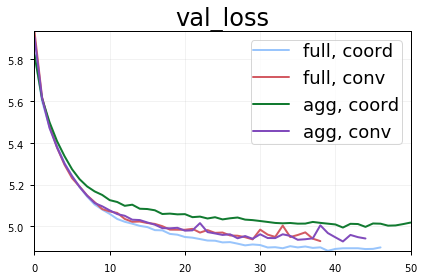

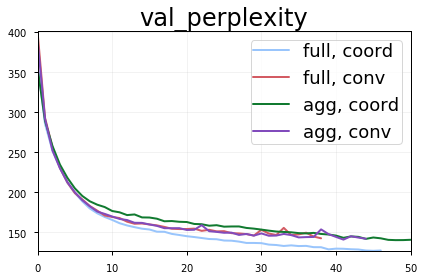

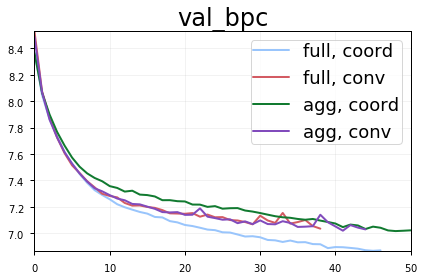

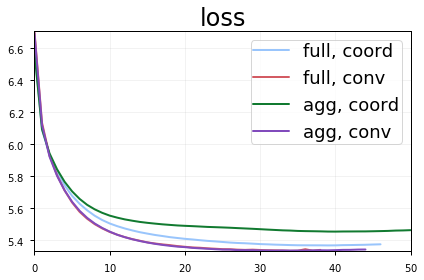

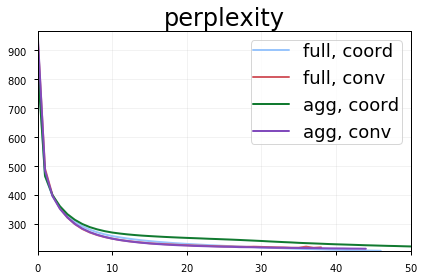

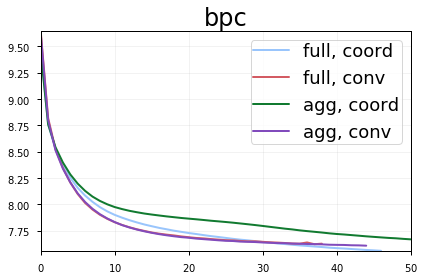

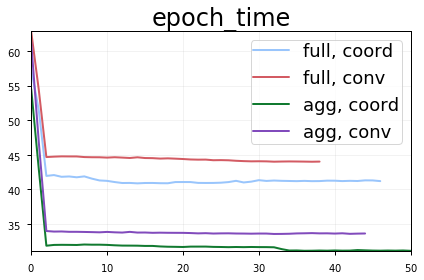

In [5]:
names = list(wikitext2_histories[key][0])

for name in names:
    for key in list(sorted(wikitext2_histories)):
        (agglom, conv, coord) = key
        label = 'agg' if agglom else 'full'
        if conv:
            label += ', conv'
        if coord:
            label += ', coord'
        
        histories = [hist[name] for hist in wikitext2_histories[key]]
        N = min(len(hist) for hist in histories)
        histories = np.array([hist[:N] for hist in histories])
        mu = np.mean(histories, axis=0)
        pp.plot(mu, label=label)
    pp.title(name)
    pp.legend()
    pp.show()

In [6]:
rows = []

for key in list(sorted(wikitext2_test_evals)):
    (agglom, conv, coord) = key
    label = 'agg' if agglom else 'full'
    if conv:
        label += ', conv'
    if coord:
        label += ', coord'
        
    epoch_times = [hist['epoch_time'] for hist in wikitext2_histories[key]]
    epoch_time = np.mean([np.mean(t[-len(t)//2:]) for t in epoch_times])
        
    row = [label, wikitext2_sizes[key], epoch_time]
        
    row.extend(np.mean(wikitext2_test_evals[key], axis=0).tolist())
    row.extend((np.std(wikitext2_test_evals[key], axis=0)/
                np.sqrt(len(wikitext2_test_evals[key]))).tolist())
        
    rows.append(row)
        
columns = (['Name', 'size', 'epoch time'] + 
           model.metrics_names + 
           [name + '_stderr' for name in model.metrics_names])
pd.DataFrame(rows, columns=columns)

Name     size  epoch time      loss  perplexity       bpc  \
0  full, coord  1500289   41.187407  4.813697  121.978559  6.780663   
1   full, conv  1614465   44.101872  4.850345  134.530780  6.931792   
2   agg, coord  1469585   31.293798  4.917208  133.941631  6.919655   
3    agg, conv  1583761   33.638878  4.851201  132.621612  6.915507   

   loss_stderr  perplexity_stderr  bpc_stderr  
0     0.002166           0.571077    0.007860  
1     0.002600           0.751170    0.007541  
2     0.011485           1.076552    0.014166  
3     0.003771           0.539609    0.006352

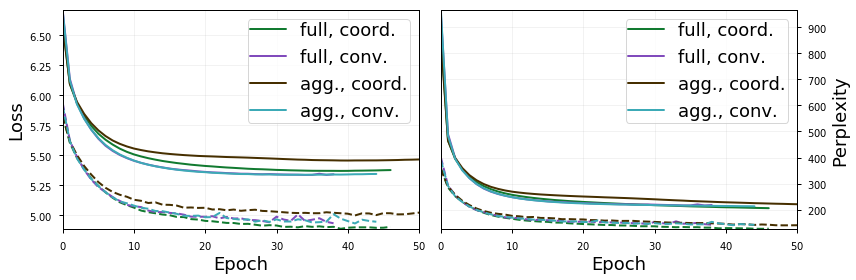

In [7]:
colors = pp.rcParams['axes.prop_cycle'].by_key()['color']

pp.figure(figsize=(2, 1)*np.array(pp.rcParams['figure.figsize']))
ax = pp.subplot(1, 2, 1);name = 'loss'
for (key, color) in zip(list(sorted(wikitext2_histories)), colors[2:]):
    (agglom, conv, coord) = key
    label = 'agg.' if agglom else 'full'
    if conv:
        label += ', conv.'
    if coord:
        label += ', coord.'

    histories = [hist[name] for hist in wikitext2_histories[key]]
    N = min(len(hist) for hist in histories)
    histories = np.array([hist[:N] for hist in histories])
    mu = np.mean(histories, axis=0)
    ax.plot(mu, label=label, color=color)
    
    val_name = 'val_{}'.format(name)
    histories = [hist[val_name] for hist in wikitext2_histories[key]]
    N = min(len(hist) for hist in histories)
    histories = np.array([hist[:N] for hist in histories])
    mu = np.mean(histories, axis=0)
    ax.plot(mu, linestyle='--', color=color)
pp.ylabel(name.capitalize())
pp.xlabel('Epoch')
# pp.gca().set_xscale('log')
# pp.gca().set_yscale('log')
pp.legend()

ax = pp.subplot(1, 2, 2);name = 'perplexity'
for (key, color) in zip(list(sorted(wikitext2_histories)), colors[2:]):
    (agglom, conv, coord) = key
    label = 'agg.' if agglom else 'full'
    if conv:
        label += ', conv.'
    if coord:
        label += ', coord.'

    histories = [hist[name] for hist in wikitext2_histories[key]]
    N = min(len(hist) for hist in histories)
    histories = np.array([hist[:N] for hist in histories])
    mu = np.mean(histories, axis=0)
    ax.plot(mu, label=label, color=color)
    
    val_name = 'val_{}'.format(name)
    histories = [hist[val_name] for hist in wikitext2_histories[key]]
    N = min(len(hist) for hist in histories)
    histories = np.array([hist[:N] for hist in histories])
    mu = np.mean(histories, axis=0)
    ax.plot(mu, linestyle='--', color=color)
    
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
pp.ylabel(name.capitalize())
pp.xlabel('Epoch')
# pp.gca().set_xscale('log')
# pp.gca().set_yscale('log')
pp.legend()
pp.savefig('../media/wikitext2_training.pdf')

# Text8 dataset

In [8]:
%%writefile text8_conversion.pl
#!/usr/bin/perl

# Program to filter Wikipedia XML dumps to "clean" text consisting only of lowercase
# letters (a-z, converted from A-Z), and spaces (never consecutive).  
# All other characters are converted to spaces.  Only text which normally appears 
# in the web browser is displayed.  Tables are removed.  Image captions are 
# preserved.  Links are converted to normal text.  Digits are spelled out.

# Written by Matt Mahoney, June 10, 2006.  This program is released to the public domain.

$/=">";                     # input record separator
while (<>) {
  if (/<text /) {$text=1;}  # remove all but between <text> ... </text>
  if (/#redirect/i) {$text=0;}  # remove #REDIRECT
  if ($text) {

    # Remove any text not normally visible
    if (/<\/text>/) {$text=0;}
    s/<.*>//;               # remove xml tags
    s/&amp;/&/g;            # decode URL encoded chars
    s/&lt;/</g;
    s/&gt;/>/g;
    s/<ref[^<]*<\/ref>//g;  # remove references <ref...> ... </ref>
    s/<[^>]*>//g;           # remove xhtml tags
    s/\[http:[^] ]*/[/g;    # remove normal url, preserve visible text
    s/\|thumb//ig;          # remove images links, preserve caption
    s/\|left//ig;
    s/\|right//ig;
    s/\|\d+px//ig;
    s/\[\[image:[^\[\]]*\|//ig;
    s/\[\[category:([^|\]]*)[^]]*\]\]/[[$1]]/ig;  # show categories without markup
    s/\[\[[a-z\-]*:[^\]]*\]\]//g;  # remove links to other languages
    s/\[\[[^\|\]]*\|/[[/g;  # remove wiki url, preserve visible text
    s/\{\{[^}]*\}\}//g;         # remove {{icons}} and {tables}
    s/\{[^}]*\}//g;
    s/\[//g;                # remove [ and ]
    s/\]//g;
    s/&[^;]*;/ /g;          # remove URL encoded chars

    # convert to lowercase letters and spaces, spell digits
    $_=" $_ ";
    tr/A-Z/a-z/;
    s/0/ zero /g;
    s/1/ one /g;
    s/2/ two /g;
    s/3/ three /g;
    s/4/ four /g;
    s/5/ five /g;
    s/6/ six /g;
    s/7/ seven /g;
    s/8/ eight /g;
    s/9/ nine /g;
    tr/a-z/ /cs;
    chop;
    print $_;
  }
}

Overwriting text8_conversion.pl


In [9]:
%%sh

# see http://mattmahoney.net/dc/textdata.html
wget --continue http://mattmahoney.net/dc/enwik9.zip

unzip -p enwik9.zip enwik9 | perl text8_conversion.pl | head -c 100000000 > text8

ls -lh

total 404M
-rw-r--r-- 1 matthew matthew 308M Sep  1  2011 enwik9.zip
-rw-r--r-- 1 matthew matthew  39K Jul 11 08:16 SI Notebook A. Size Benchmarks.ipynb
-rw-r--r-- 1 matthew matthew 396K Jul 12 06:48 SI Notebook B. Language Modeling.ipynb
-rw-r--r-- 1 matthew matthew  96M Jul 12 07:18 text8
-rw-r--r-- 1 matthew matthew 2.0K Jul 12 07:17 text8_conversion.pl


--2019-07-12 07:17:59--  http://mattmahoney.net/dc/enwik9.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [10]:
text8_data = np.memmap('text8', mode='r')

# remove spaces in the ASCII character set, given that we have a-z and ' '
# reserve index 0 for masking later, if desired
compressed_characters = [0]

compressed_characters.extend(range(ord('a'), ord('z') + 1))
compressed_characters.append(ord(' '))

compressed_characters = np.array(compressed_characters, dtype=np.uint8)

compress_character_map = np.zeros(256, dtype=np.uint8)
for (i, j) in enumerate(compressed_characters):
    compress_character_map[j] = i
    
vocabulary_size = len(compressed_characters)
embedding_size = 64
num_heads = 8
    
def random_batch(batch_size, seq_len, use_fractions=(0, 1.)):
    N = len(text8_data)
    whole_start_index = int(N*use_fractions[0])
    whole_end_index = int(N*use_fractions[1])
    
    while True:
        start_indices = np.random.randint(
            whole_start_index, whole_end_index - seq_len, 
            size=batch_size)
        end_indices = start_indices + seq_len + 1

        slices = np.array(
            [compress_character_map[text8_data[start:end]] 
             for (start, end) in zip(start_indices, end_indices)],
            dtype=text8_data.dtype)

        inputs = slices[:, :-1]
        outputs = slices[:, 1:, np.newaxis]
        yield (inputs, outputs)
        
def train_text8(batch_size, max_seq_length, agglomerative_attention,
                epochs, validation_fraction=.3, test_fraction=.1,
                epoch_scaling_factor=1, use_convolutions=True, 
                use_coordinate_embeddings=True):
    
    model, model_callbacks = get_model(
        max_seq_length, agglomerative_attention, 
        vocabulary_size, embedding_size, num_heads, 
        use_convolutions=use_convolutions, 
        use_coordinate_embeddings=use_coordinate_embeddings,
        convolution_width=8)
    
    fractions = 1 - np.cumsum([test_fraction, validation_fraction])[::-1]
    train_data = random_batch(batch_size, max_seq_length, (0, fractions[0]))
    val_data = random_batch(batch_size, max_seq_length, (fractions[0], fractions[1]))
    test_data = random_batch(batch_size, max_seq_length, (fractions[1], 1))
    
    steps_per_epoch = int(epoch_scaling_factor*fractions[0]*
                          len(text8_data)/max_seq_length/batch_size)
    validation_steps = int(steps_per_epoch*
                           validation_fraction/fractions[0])
    test_steps = int(steps_per_epoch*
                     test_fraction/fractions[0])

    model.fit_generator(
        train_data, 
        steps_per_epoch=steps_per_epoch,
        validation_data=val_data,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=model_callbacks,
        verbose=False,
    )
    
    test_evals = model.evaluate_generator(
        test_data, 
        steps=test_steps,
        verbose=False)
    
    return model, test_evals
        

In [ ]:
batch_size = 32
seq_len = 128
epochs = 400

aggloms = [False, True]
convolutions = [False, True]
coords = [False, True]
replicas = list(range(5))

text8_histories = collections.defaultdict(list)
text8_sizes = {}
text8_test_evals = collections.defaultdict(list)

for (agglom, conv, coord, _) in itertools.product(
        aggloms, convolutions, coords, replicas):
    # skip models that won't include any notion of time
    if not coord and not conv:
        continue
    # also skip models that include both
    if coord and conv:
        continue
        
    key = (agglom, conv, coord)
    
    (model, test_evals) = train_text8(
        batch_size, seq_len, agglom, epochs, epoch_scaling_factor=.1, 
        use_convolutions=conv, use_coordinate_embeddings=coord)
    
    text8_histories[key].append(model.history.history)
    text8_sizes[key] = sum(v.size for v in model.get_weights())    
    text8_test_evals[key].append(test_evals)


/usr/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


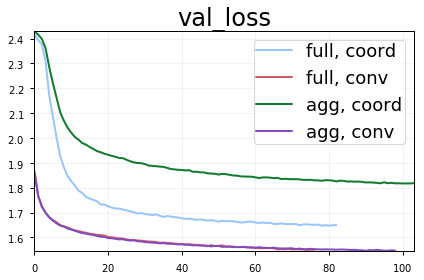

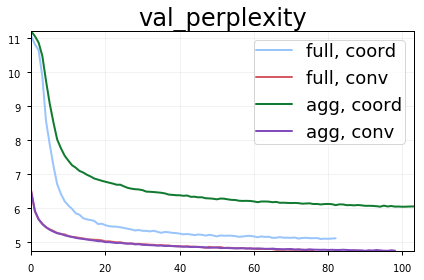

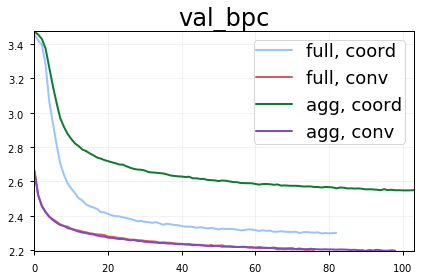

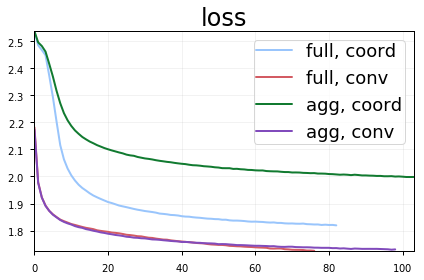

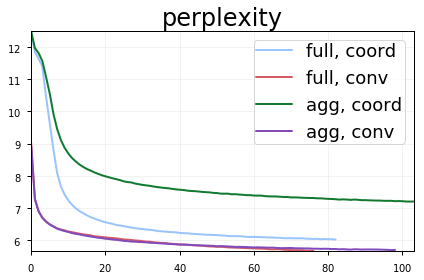

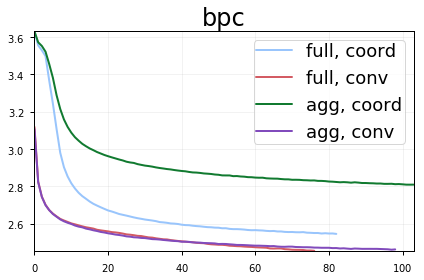

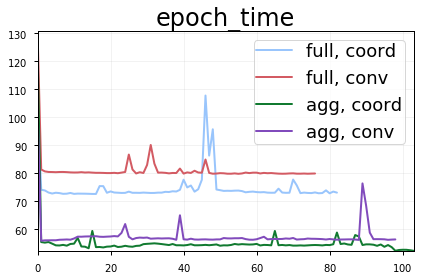

In [12]:
names = list(text8_histories[key][0])

for name in names:
    for key in list(sorted(text8_histories)):
        (agglom, conv, coord) = key
        label = 'agg' if agglom else 'full'
        if conv:
            label += ', conv'
        if coord:
            label += ', coord'
        
        histories = [hist[name] for hist in text8_histories[key]]
        N = min(len(hist) for hist in histories)
        histories = np.array([hist[:N] for hist in histories])
        mu = np.mean(histories, axis=0)
        pp.plot(mu, label=label)
    pp.title(name)
    pp.legend()
    pp.show()

In [13]:
rows = []

for key in list(sorted(text8_test_evals)):
    (agglom, conv, coord) = key
    label = 'agg' if agglom else 'full'
    if conv:
        label += ', conv'
    if coord:
        label += ', coord'
        
    epoch_times = [hist['epoch_time'] for hist in text8_histories[key]]
    epoch_time = np.mean([np.mean(t[-len(t)//2:]) for t in epoch_times])
        
    row = [label, text8_sizes[key], epoch_time]
        
    row.extend(np.mean(text8_test_evals[key], axis=0).tolist())
    row.extend((np.std(text8_test_evals[key], axis=0)/
                np.sqrt(len(text8_test_evals[key]))).tolist())
        
    rows.append(row)
        
columns = (['Name', 'size', 'epoch time'] + 
           model.metrics_names + 
           [name + '_stderr' for name in model.metrics_names])
pd.DataFrame(rows, columns=columns)

Name   size  epoch time      loss  perplexity       bpc  \
0  full, coord  64193   75.283314  1.629490    4.998184  2.271242   
1   full, conv  88513   80.881370  1.532781    4.674585  2.176720   
2   agg, coord  57041   53.961555  1.797411    5.922431  2.519678   
3    agg, conv  81361   57.104206  1.536918    4.696823  2.182780   

   loss_stderr  perplexity_stderr  bpc_stderr  
0     0.003314           0.019285    0.004817  
1     0.002683           0.012325    0.003969  
2     0.008995           0.053551    0.013428  
3     0.002331           0.013164    0.003538

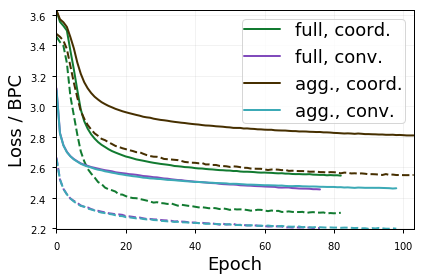

In [14]:
colors = pp.rcParams['axes.prop_cycle'].by_key()['color']

name = 'bpc'
for (key, color) in zip(list(sorted(text8_histories)), colors[2:]):
    (agglom, conv, coord) = key
    label = 'agg.' if agglom else 'full'
    if conv:
        label += ', conv.'
    if coord:
        label += ', coord.'

    histories = [hist[name] for hist in text8_histories[key]]
    N = min(len(hist) for hist in histories)
    histories = np.array([hist[:N] for hist in histories])
    mu = np.mean(histories, axis=0)
    pp.plot(mu, label=label, color=color)
    
    val_name = 'val_{}'.format(name)
    histories = [hist[val_name] for hist in text8_histories[key]]
    N = min(len(hist) for hist in histories)
    histories = np.array([hist[:N] for hist in histories])
    mu = np.mean(histories, axis=0)
    pp.plot(mu, linestyle='--', color=color)
    
pp.ylabel('Loss / BPC')
pp.xlabel('Epoch')
# pp.gca().set_xscale('log')
# pp.gca().set_yscale('log')
pp.legend()
pp.savefig('../media/text8_training.pdf')